In [2]:
import tensorflow_probability as tfp
import tensorflow as tf
import pandas as pd

tfd = tfp.distributions 

import setup.input_functions as setfun

# Poisson Regression Model

## Background: Case Study
For demonstration purposes, we adapt an example from Johnson et al. (2022), which investigates the number of LGBTQ+ anti-discrimination laws in each US state. The distribution of these laws is assumed to follow a Poisson distribution, with the rate of such laws being influenced by demographic and voting trend. The demographic trend is quantified by the percentage of a state’s residents living in urban areas, ranging from 38.7\% to 94.7\%. Additionally, the voting trend is represented by
historical voting patterns in presidential elections, categorizing each state as consistently voting for the Democratic or Republican candidate or being a Swing state. We employ a Poisson regression model including one treatment-coded categorical predictor: the voting trend. This predictor has three levels: Democrats, Republicans, and Swing, with Democrats serving as the reference category. Furthermore, the model incorporates one continuous predictor: the demographic trend, measured as
a percentage. 

**Reference**

Johnson, A. A., Ott, M. Q., & Dogucu, M. (2022). *Bayes rules!: An introduction to applied Bayesian modeling*. CRC Press.

## Data generating model
\begin{align*}
    y_i &\sim \text{Poisson}(\theta_i)\\
    \text{log}(\theta_i) &= \beta_0 + \beta_1x_1 + \beta_2 x_2 + \beta_3 x_3\\
    \beta_k &\sim \text{Normal}(\mu_k, \sigma_k) \quad \text{for }k=0,\ldots,3\\
\end{align*}
Here, $y_i$ is the number of counts for observation $i = 1, \ldots, N$. The counts follow a Poisson distribution with rate $\theta_i$. The rate parameter is predicted by a linear combination of two predictors: the continuous predictor $x_1$ with slope $\beta_1$ and a three-level factor represented by the coefficients $\beta_2$ and $\beta_3$ for both contrasts $x_2$ and $x_3$. The logged average count $y$ is denoted by $\beta_0$. All regression coefficients are assumed to have normal prior distributions with mean $\mu_k$ and standard deviation $\sigma_k$ for $k = 0, \ldots, 3$. The log-link function maps $\theta_i$ to the scale of the linear predictor. The main goal is to learn the hyperparameters $\lambda = (\mu_k , \sigma_k)$ based on expert knowledge.

## Methodology: Workflow

+ PriorSamples($\lambda = (\mu_k, \sigma_k)$):
\begin{align*}
\{\beta_k\}_s &\sim \text{Normal}(\mu_k, \exp\{\sigma_k\})\\
\end{align*}
+ Generator($\beta_k$):
\begin{align*}
\{\text{log}(\theta_i)\}_s &= \{\beta_k\}_s \times X_i\\
\{y_i\}_s &\sim \text{Poisson}(\{\theta_i\}_s)\\
\end{align*}
+ Targets($\{y_j\}_s$, $\{\bar{y}_G\}_s$):
\begin{align*}
\{y_j\}_s &= \{y_j\}_s \quad \text{ for } j = 1,11,17,22,35,44\\
\{\bar{y}_G\}_s &= \frac{1}{\mid G \mid} \sum_{i\in G}\mathbb 1_G (\{y_i\}_s) \quad \text{ with G = Democratic, Republican, Swing}\\
\end{align*}
+ Elicits($\{y_{j}\}_s, \{R^2\}_s$)
\begin{align*}
\text{Histogram-based:}& \quad \{y_j\}_s = \{y_j\}_s \quad \text{ for } j = 1,11,17,22,35,44\\
\text{Quantile-based:}& \quad Q_p^{G} = Q_{p}^{G} \{\bar{y}_G\}_s \quad \text{G = Democratic, Republican, Swing, } p = 0.1, \ldots, 0.9\\
\end{align*}

## Setting up the method

### Model parameters
First, we need to specify the parameters in the generative model using the `param()` function which requires the following input:
+ `name`: the name of the model parameter
    + In our Poisson model we have four model parameters which we will denote as *b0*,*b1*,*b2*, and *b3*
+ `family`: the prior distribution family
    + We assume a Normal prior distribution for each model parameter 
    + We created a wrapper around the Normal distribution as implemented in tensorflow-probability in order to learn the $\sigma$-hyperparameter on the log-scale.
+ `hyperparams_dict`: a dictionary including the name of the hyperparameter values and the initial value for the learning algorithm
    + We use distributions from which an initial value is drawn.
    + When a hyperparameter is learned on the log-scale, we indicate this by writing "log_" before the actual name of the hyperparameter, such as *log_sigma0*.

In [3]:
from user_input.custom_functions import Normal_log

normal_log = Normal_log()
    
def model_params():  
    return (
        setfun.param(name = "b0", 
              family = normal_log, 
              hyperparams_dict = {"mu0": tfd.Uniform(1.,2.5), 
                                  "log_sigma0": tfd.Uniform(-2.,-5.)}
              ),
        setfun.param(name = "b1", 
              family = normal_log, 
              hyperparams_dict = {"mu1": tfd.Uniform(0.,0.5), 
                                  "log_sigma1": tfd.Uniform(-2.,-5.)}
              ),
        setfun.param(name = "b2", 
              family = normal_log, 
              hyperparams_dict = {"mu2": tfd.Uniform(-1.,-1.5), 
                                  "log_sigma2": tfd.Uniform(-2.,-5.)}
              ),
        setfun.param(name = "b3", 
              family = normal_log, 
              hyperparams_dict = {"mu3": tfd.Uniform(-0.5,-1.), 
                                  "log_sigma3": tfd.Uniform(-2.,-5.)}
              )
        )

### Expert data or ground truth for method validation

Next, we define the `expert()` function which represents the data input based on which the method has to learn. 
This can be either 
+ data from an expert (in this case the argument `data` expects a string with the location to the expert data) or
+ an expected ground truth in which case we simulate once from the method using a pre-defined hyperparameter vector $\lambda^*$ and learn then on this simulated data (in this case we need to set the argument `simulate_data = True` and specify the true hyperparameter values in `simulator_specs`.
    
The second approach is helpful when we want to validate our method and check whether the implementation is correct. Because it allows us to check whether we can recover an expected ground truth under *ideal circumstances*.

In [4]:
def expert_input():
    return setfun.expert(data = None,
                        simulate_data = True,
                        simulator_specs = {
                          "b0": tfd.Normal(2.91, 0.07),
                          "b1": tfd.Normal(0.23, 0.05),
                          "b2": tfd.Normal(-1.51, 0.135),
                          "b3": tfd.Normal(-0.61, 0.105)
                          })

### Generative model

Now, we can define our generative model from which data should be simulated. We specified the model already formally. 
For implementation purposes a particular *input-output* structure is required:
+ input:
    + (required) `prior_samples`: samples drawn from the prior distributions 
    + (optional) `design_matrix`: design matrix used for the regression model
+ output:
    + (required) `likelihood`: model likelihood
    + (required) `ypred`: prior predictions (if likelihood is discrete `ypred=None` as it will be approximated using the Softmax-Gumble method)
    + (required) `epred`: linear predictor
    + (optional) `prior_samples`: we use it here again as output for easier follow-up computations 

In [5]:
class GenerativePoissonModel(tf.Module):
    def __call__(self, 
                prior_samples,        
                design_matrix,       
                **kwargs        
                ):  
        
        # linear predictor
        theta = design_matrix @ tf.expand_dims(prior_samples, -1)
        
        # map linear predictor to theta
        epred = tf.exp(theta)
        
        # define likelihood
        likelihood = tfd.Poisson(
            rate = epred
        )
        
        return dict(likelihood = likelihood,     
                    ypred = None,   
                    epred = epred[:,:,:,0],
                    prior_samples = prior_samples               
                    )

After having specified the generative model, we load all information into the `model()` function which requires the following specifications:
+ `generative_model`: the class of the generative model (callable)
+ `additional_model_args`: specifications of model arguments used as input that are not prior samples
    + in this example we have additionally the *design_matrix*. The argument name must match with the argument of the generative model and the value is then the corresponding value (here the design matrix)
+ `discrete_likelihood`: whether likelihood is discrete or not; if *True* the softmax-gumble method will be used in order to approximate `ypred`
+ `softmax_gumble_specs`: Additional settings required by the softmax-gumble method.
    + `temperature`: (default) $1.$ (for smaller values tending towards zero the Gumbel-Softmax distr. is equiv. to the categorical distr.)
    + `upper_threshold`: (required) if likelihood is unbounded, the upper threshold argument specifies where to truncate the distribution. Currently, we have only implemented the case where distributions lack an upper bound.

In [6]:
from user_input.generative_models import GenerativePoissonModel
from user_input.design_matrices import load_design_matrix_equality

design_matrix = load_design_matrix_equality("standardize", selected_obs = [0, 13, 14, 35, 37, 48])

def generative_model():
    return setfun.model(
        GenerativePoissonModel,
        additional_model_args = {
             "design_matrix": design_matrix
        },
        discrete_likelihood = True,
        softmax_gumble_specs = {
            "temperature": 1.,
            "upper_threshold": 80
        }
        )

### Target quantities and elicitation techniques
In the next step, we can define the target quantities and the corresponding elicitation technique. Both is specified through the `target()` function which has the following options:
+ `name`: name of the target quantity
    + if you want to use a target quantity which is already specified in the generative model, then you the value for `name` must match with the output argument from the generative model. For this example, `ypred` is taken directly from the generative model.
+ `custom_target_function`: (optional) it is possible to compute custom target quantities from the output of the generative model. Here we compute for example the group means based on the prior predictions. If a custom target function is used the following specifications have to be done:
    + `function`: the respective custom function (callable)
    + `additional_args`: in case the custom function takes as arguments parameters that are not in the output of the generative model, these parameters need to be specified here in form of a dictionary. The argument name is used as key and the respective value. 
+ `elicitation_method`: currently available elicitation methods are *histogram*, *moments*, and *quantiles*
    + some of the elicitation methods require additional specifications:
        + *moments* requires the additional argument `moments_specs` which takes a tuple with the moments that should be elicited e.g. ("mean", "sd")
        + *quantiles* requires the additional argument `quantiles_specs` which takes a tuple with the percentages that should be elicited e.g. (25, 50, 75)
+ `loss_components`: specifies the form of the loss components. Possible values are *by-group*, *by-stats*,*all*. (Detailed description will follow)

In [7]:
from user_input.custom_functions import custom_group_means
    
def target_quantities():
    return (
        setfun.target(name = "ypred",
               elicitation_method = "histogram",
               loss_components = "by-group"
               ),
        setfun.target(
            name = "group_means",
            elicitation_method = "quantiles",
            quantiles_specs = (25, 50, 75),
            custom_target_function = {
                "function": custom_group_means,
                "additional_args": {
                    "design_matrix": design_matrix,
                    "factor_indices": [0,2,3]
                }
            },
            loss_components = "by-group"
            )
        )

### Loss function and optimization settings

The loss function used to compute the discrepancy between the expert and the model-implied elicited statistics is specified via the `loss()` function which has the following arguments:
+ `loss_function`: the discrepancy measure (string: *mmd-energy* or callable)
+ `loss_weighting`: if a weighting scheme for the multiobjective loss function should be used.

For the optimization settings, we consider for the moment only batch stochastic gradient descent for which we need to specify the optimizer using the `optimization()` function, which takes two arguments:
+ `optimizer`: The optimizer that should be used for the current case study (here we use the Adam optimizer)
+ `optimizer_specs`: If further specifications of the optimizer are needed, they are specified here. For the Adam optimizer we need for example an initial learning rate. The additional keyword arguments are specified in form of a dictionary with the key matching the argument name. In this case study we use a cosine decay learning rate schedule with restarts. And we clip the gradient norm at 1.

In [8]:
def loss_function():
    return setfun.loss(
        loss_function = "mmd-energy",
        loss_weighting = None
        )

def optimization_settings():
    return setfun.optimization(
        optimizer = tf.keras.optimizers.Adam,
        optimizer_specs = {
            "learning_rate": tf.keras.optimizers.schedules.CosineDecayRestarts(
                0.01, 50),
            "clipnorm": 1.0
        })

### Run the learning algorithm
Finally we can wrap everything up and run the learning algorithm. Therefore we specify the last hyperparameter needed by the learning algorithm with the following `prior_elicitation()` function:
+ `method`: method for learning the prior distributions (currently available: *parametric_prior*)
+ `sim_id`: unique name of model (also used for saving results)
+ `B`: batch size
+ `rep`: number of simulations from the prior distributions
+ `seed`: seed for the current simulation
+ `burnin`: runs before learning starts in order to find good initial values (if drawn randomly)
+ `epochs`: number of learning cycles until learning stops
+ `output_path`: file location for storing results 

In [ ]:
setfun.prior_elicitation(
        method = "parametric_prior",
        sim_id = "pois_34765558",
        B = 128,
        rep = 300,
        seed = 34765558,
        burnin = 10,
        epochs = 700,
        output_path = "results",
        model_params = model_params,
        expert_input = expert_input,
        generative_model = generative_model,
        target_quantities = target_quantities,
        loss_function = loss_function,
        optimization_settings = optimization_settings,
        log_info = 0,
        print_info=True,
        view_ep = 1
        )

## Evaluating method performance

In [1]:
import validation.plotting as vp
from vp.plot_learned_prior import learned_prior_pois
from vp.plot_diagnostics import diagnostics_pois

path = "../sim_results/"
file = "pois_34765682_200"
selected_obs = [0, 13, 14, 35, 37, 48]
true_values = [2.91, 0.07, 0.23, 0.05, -1.51, 0.135, -0.61, 0.105]

### Convergence diagnostics

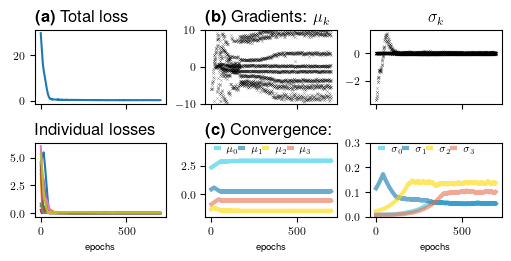

In [10]:
# plot diagnostics
diagnostics_pois(path, file, save_fig = False)

### Learned prior distributions

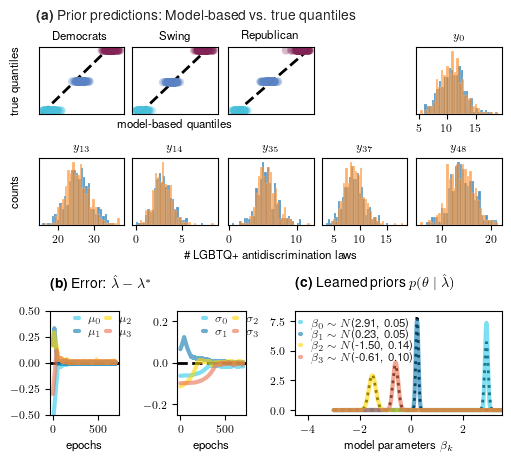

In [11]:
# plot learned prior distributions
learned_prior_pois(path, file, selected_obs, true_values, 
                    last_vals = 30, save_fig = False)

### Summary output

In [2]:
from setup.write_results import model_summary
import pandas as pd

# get global dictionary
global_dict = pd.read_pickle(path+file+"/global_dict.pkl")

# print summary of method specifications
model_summary(path+file, global_dict)

General summary
---------------- 
method=parametric_prior
sim_id=pois_34765682_200
seed=34765682
B=128
rep=300
epochs=700
wall time=187:16 (min:sec)
optimizer=<class 'keras.src.optimizers.adam.Adam'>
learning rate={'lr_scheduler': <keras.src.optimizers.schedules.learning_rate_schedule.CosineDecayRestarts object at 0x000002D30B57BE20>, 'init_lr': 0.01, 'decay_steps': 50}

Model info
---------------- 
model name=<class 'user_input.generative_models.GenerativePoissonModel'>
model parameters=['b0', 'b1', 'b2', 'b3']

Parametric Prior
---------------- 
distribution family={'b0': 'Normal_log_scale', 'b1': 'Normal_log_scale', 'b2': 'Normal_log_scale', 'b3': 'Normal_log_scale'}
initialization={'mu0': {'low': 1.0, 'high': 2.5, 'name': 'Uniform'}, 'log_sigma0': {'low': -2.0, 'high': -5.0, 'name': 'Uniform'}, 'mu1': {'low': 0.0, 'high': 0.5, 'name': 'Uniform'}, 'log_sigma1': {'low': -2.0, 'high': -5.0, 'name': 'Uniform'}, 'mu2': {'low': -1.0, 'high': -1.5, 'name': 'Uniform'}, 'log_sigma2': {'low'